In [62]:
import numpy as np
import matplotlib.pyplot as plt

Let's say our embedding size is 2.

Consider some words and assign some reasonable embeddings to them.

In [77]:
embeddings_map = {
    "cat": [0.9, 0.5],
    "dog": [0.8, 0.6],
    "apple": [-0.5, 0.8],
    "banana": [-0.3, 0.9],
    "furniture": [0.2, -0.7],
    "house": [-0.1, -0.6],
}
embeddings = np.stack(list(embeddings_map.values()))

xs = embeddings[:, 0]
ys = embeddings[:, 1]
rs = np.sqrt(xs**2 + ys**2)
radians = np.arctan2(ys, xs)
degrees = np.rad2deg(radians)

embeddings.shape

(6, 2)

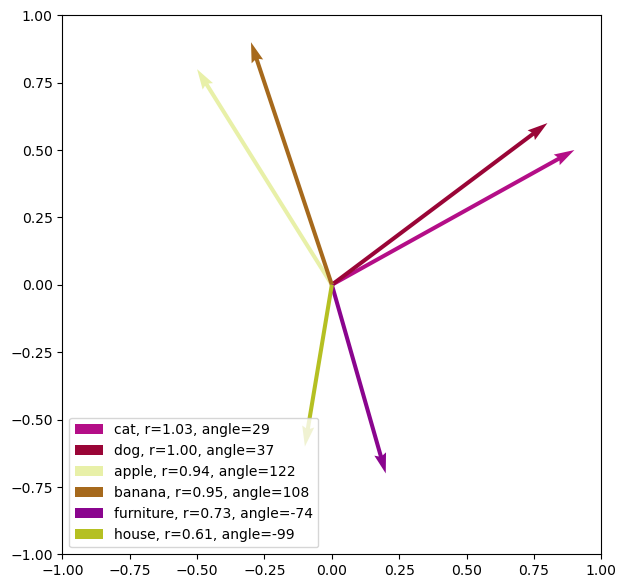

In [78]:
# Draw the vectors
plt.figure(figsize=(7, 7))
for i, name in enumerate(embeddings_map):
    x, y = embeddings[i]
    r = rs[i]
    angle = degrees[i]
    plt.quiver(
        0,
        0,
        x,
        y,
        angles="xy",
        scale_units="xy",
        scale=1,
        label=f"{name}, r={r:.02f}, angle={angle:.0f}",
        color=np.random.rand(3).tolist(),
    )
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")
plt.legend(loc="lower left")
plt.show()

Now, let's say we want to rotate all the embeddings by 70 degrees.

- r is the norm of the vector
- radians is the angle of the vector with the x-axis.
- t is the angle by which we want to rotate the vector in radians.
- x' = r * cos(radians + theta)
- y' = r * sin(radians + theta)

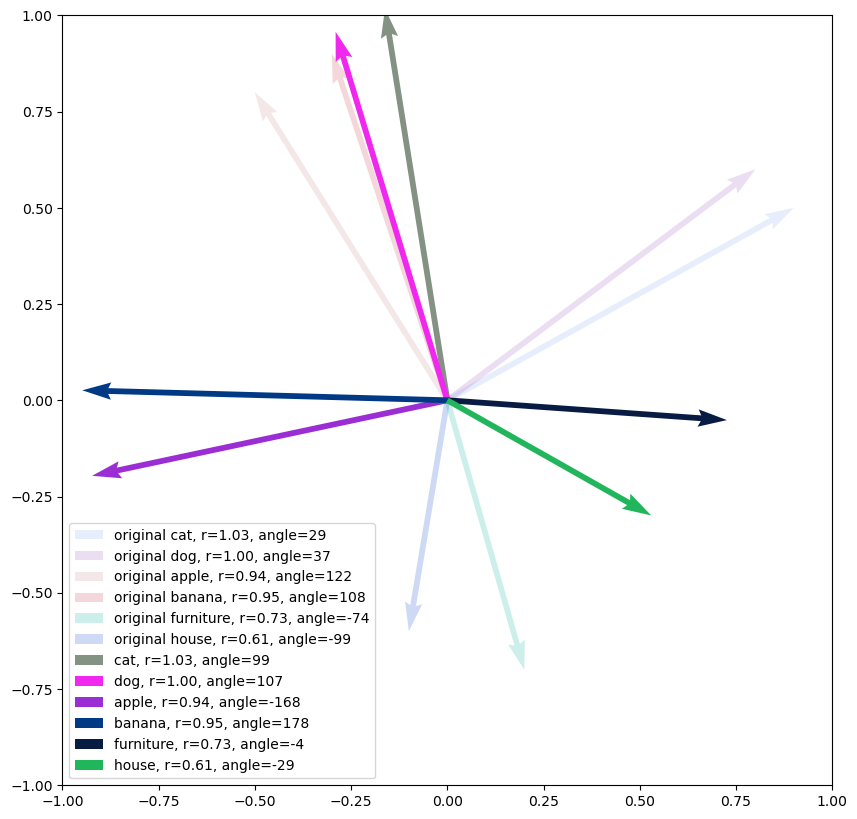

In [129]:
t = np.deg2rad(70)

xs_rotated = rs * np.cos(radians + t)
ys_rotated = rs * np.sin(radians + t)

# Alternative way to rotate the vectors. Try it.
# xs_rotated = xs * np.cos(t) - ys * np.sin(t)
# ys_rotated = xs * np.sin(t) + ys * np.cos(t)

embeddings_rotated = np.stack([xs_rotated, ys_rotated], axis=1)

rs_rotated = np.sqrt(xs_rotated**2 + ys_rotated**2)
radians_rotated = np.arctan2(ys_rotated, xs_rotated)
degrees_rotated = np.rad2deg(radians_rotated)

plt.figure(figsize=(10, 10))
for i, name in enumerate(embeddings_map):
    # Original vector
    x, y = embeddings[i]
    r = rs[i]
    angle = degrees[i]
    plt.quiver(
        0,
        0,
        x,
        y,
        angles="xy",
        scale_units="xy",
        scale=1,
        label=f"original {name}, r={r:.02f}, angle={angle:.0f}",
        color=np.random.rand(3).tolist(),
        linestyle="--",
        alpha=0.2,
    )

for i, name in enumerate(embeddings_map):
    # Rotated vector
    x, y = embeddings_rotated[i]
    r = rs_rotated[i]
    angle = degrees_rotated[i]
    plt.quiver(
        0,
        0,
        x,
        y,
        angles="xy",
        scale_units="xy",
        scale=1,
        label=f"{name}, r={r:.02f}, angle={angle:.0f}",
        color=np.random.rand(3).tolist(),
    )
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")
plt.legend(loc="lower left")
plt.show()

Now, let's concatenate the original embeddings with the rotated embeddings.

Notice how the rotated dog vector is very close to the original banana vector.

Although relative positions are preserved, the meaning of the embeddings have changed.

The original vector banana is now dog.

In [130]:
np.concatenate((embeddings, embeddings_rotated), axis=1)

array([[ 0.9       ,  0.5       , -0.16202818,  1.01673343],
       [ 0.8       ,  0.6       , -0.29019946,  0.95696618],
       [-0.5       ,  0.8       , -0.92276417, -0.1962302 ],
       [-0.3       ,  0.9       , -0.9483294 ,  0.02591034],
       [ 0.2       , -0.7       ,  0.72618886, -0.05147558],
       [-0.1       , -0.6       ,  0.52961356, -0.29918135]])

The magnitudes (l2 norms) of the original and rotated vectors are the same.

In [131]:
np.stack((rs, rs_rotated), axis=1)

array([[1.02956301, 1.02956301],
       [1.        , 1.        ],
       [0.94339811, 0.94339811],
       [0.9486833 , 0.9486833 ],
       [0.72801099, 0.72801099],
       [0.60827625, 0.60827625]])

The angles of the original and rotated vectors are different.

They are different by 70 degrees.

We can either do cos(radians + t) or (cos(radians)*cos(t) - sin(radians)*sin(t)) to get the rotated x.

Similarly to get sin(radians + t) we can do sin(radians)*cos(t) + cos(radians)*sin(t).

Replace this above and check the vector positions.

In [132]:
np.stack((degrees, degrees_rotated, (degrees_rotated - degrees) % 360), axis=1)

array([[  29.0546041 ,   99.0546041 ,   70.        ],
       [  36.86989765,  106.86989765,   70.        ],
       [ 122.00538321, -167.99461679,   70.        ],
       [ 108.43494882,  178.43494882,   70.        ],
       [ -74.0546041 ,   -4.0546041 ,   70.        ],
       [ -99.46232221,  -29.46232221,   70.        ]])

The information for each vector can be contained in any of the following forms:

(x, y) or (r, radian),

x_rotated, y_rotated can be obtained from (x, y, t) or (r, radian, t).

We don't need r and radian explicitly, we can use x, y and t to get x_rotated, y_rotated.

Formally, `x_rotated = fx(x, y, t)` and `y_rotated = fy(x, y, t)`.

```
fx(x, y, t) = x * cos(t) - y * sin(t)
fy(x, y, t) = x * sin(t) + y * cos(t)
```

This can be written in matrix form as:

```
| x_rotated |   | cos(t) -sin(t) | | x |
| y_rotated | = | sin(t)  cos(t) | | y |
```

Let's try it in code.

In [150]:
xy = embeddings.T  # (2, 6)
rotation_matrix = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])  # (2, 2)

xy.shape, rotation_matrix.shape

((2, 6), (2, 2))

In [155]:
xy_rotated = rotation_matrix @ xy  # (2, 6)
xy_rotated = xy_rotated.T  # (6, 2)
xy_rotated.shape

(6, 2)

In [159]:
# Verify that the rotated embeddings are the same as the ones we calculated before.
assert np.allclose(xy_rotated, embeddings_rotated)
np.concatenate((embeddings_rotated, xy_rotated), axis=1)

array([[-0.16202818,  1.01673343, -0.16202818,  1.01673343],
       [-0.29019946,  0.95696618, -0.29019946,  0.95696618],
       [-0.92276417, -0.1962302 , -0.92276417, -0.1962302 ],
       [-0.9483294 ,  0.02591034, -0.9483294 ,  0.02591034],
       [ 0.72618886, -0.05147558,  0.72618886, -0.05147558],
       [ 0.52961356, -0.29918135,  0.52961356, -0.29918135]])

In [ ]:
# TODO: Rotate using torch.complex64 datatype.